Example authorship comming from: https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb 

# Using Lime with Pytorch

In this tutorial we will show how to use Lime framework with Pytorch. Specifically, we will use Lime to explain the prediction generated by one of the pretrained ImageNet models.

Let's start with importing our dependencies. This code is tested with Pytorch 1.0 but should work with older versions as well.

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

import torch
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import transforms

import torch.nn.functional as F

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

Load our test image and see how it looks.

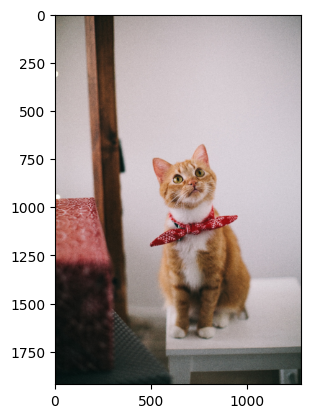

In [2]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('data/cat.png')
plt.imshow(img)

We need to convert this image to Pytorch tensor and also apply whitening as used by our pretrained model.

In [3]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])      
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

Load the pretrained model for Resnet50 available in Pytorch.

In [4]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)

Get the predicition for our image.

In [5]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

Predicitions we got are logits. Let's pass that through softmax to get probabilities and class labels for top 5 predictions.
(Load label texts for ImageNet predictions so we know what model is predicting)


In [6]:
from utils.utils import get_class_name_imagenet
probs = F.softmax(logits, dim=1).squeeze()
p, c = probs.topk(5)
[print("Class ***{}*** (idx:{}) has probability: {:.3f}".format(get_class_name_imagenet(c[_i]),c[_i],p[_i])) for _i in range(p.shape[0])]

Class ***tiger cat*** (idx:282) has probability: 0.186
Class ***tabby*** (idx:281) has probability: 0.078
Class ***Egyptian cat*** (idx:285) has probability: 0.021
Class ***bow tie*** (idx:457) has probability: 0.016
Class ***toy poodle*** (idx:265) has probability: 0.011


[None, None, None, None, None]

We are getting ready to use Lime. Lime produces the array of images from original input image by pertubation algorithm. So we need to provide two things: (1) original image as numpy array (2) classification function that would take array of purturbed images as input and produce the probabilities for each class for each image as output. 

For Pytorch, first we need to define two separate transforms: (1) to take PIL image, resize and crop it (2) take resized, cropped image and apply whitening.

In [7]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():   
    transf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])  
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

Now we are ready to define classification function that Lime needs. The input to this function is numpy array of images where each image is ndarray of shape (channel, height, width). The output is numpy aaray of shape (image index, classes) where each value in array should be probability for that image, class combination.

In [8]:
def batch_predict(images):
    with torch.no_grad():
        batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        batch = batch.to(device)
        
        logits = model(batch)
        probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

Let's test our function for the sample image.

In [9]:
test_pred = batch_predict([pill_transf(img)])
print('Predicted classs: ', test_pred.squeeze().argmax())
print('Predicted values type:',type(test_pred))
print('Predicted values shape:',test_pred.shape)
print('Predicted values:',test_pred)

Predicted classs:  282
Predicted values type: <class 'numpy.ndarray'>
Predicted values shape: (1, 1000)
Predicted values: [[3.3402696e-04 4.4319531e-04 4.7896025e-04 4.8188865e-04 3.5102607e-04
  4.8719300e-04 3.2646992e-04 3.3082851e-04 7.8777538e-04 3.4620144e-04
  4.4335911e-04 4.8777432e-04 2.8548739e-04 3.8326925e-04 4.2878071e-04
  6.2696816e-04 4.4017620e-04 3.4475702e-04 4.4498019e-04 4.3763628e-04
  5.7404710e-04 4.7773425e-04 3.3823590e-04 3.8650341e-04 5.0838012e-04
  4.3392548e-04 2.8275573e-04 3.8357568e-04 3.4579326e-04 4.3308249e-04
  5.3303823e-04 4.0127966e-04 3.2533659e-04 3.1160330e-04 4.4316467e-04
  3.1782853e-04 6.0806301e-04 3.4863286e-04 3.5642576e-04 3.8554051e-04
  5.6418416e-04 3.7773588e-04 5.2325212e-04 3.6573014e-04 6.7481451e-04
  4.0517800e-04 5.6092464e-04 3.3546481e-04 4.7828496e-04 6.8933092e-04
  7.0025446e-04 4.2110737e-04 4.7562199e-04 2.7768291e-04 5.2056590e-04
  4.2236084e-04 3.3573655e-04 4.7439887e-04 4.3982288e-04 4.5438131e-04
  5.1702710e-0

Test it for multiple images

In [10]:
img1 = get_image('data/cat.png')
img2 = get_image('data/ski.png')
test_pred = batch_predict([pill_transf(img1), pill_transf(img2)])
print('Two predictions made:',test_pred.shape)

for _i,t in enumerate(test_pred):
    print('{} - image represents class with index: {}'.format(_i,t.squeeze().argmax()))

Two predictions made: (2, 1000)
0 - image represents class with index: 282
1 - image represents class with index: 795


Import lime and create explanation for this prediciton.

In [11]:
from lime import lime_image

# Inherits from scikit-image: https://github.com/marcotcr/lime/blob/master/lime/wrappers/scikit_image.py
# Check segmentation algorithms: https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.felzenszwalb
from lime.wrappers.scikit_image import SegmentationAlgorithm 


***LIME_IMAGE_EXPLAINER***:
Explains predictions on Image (i.e. matrix) data. 
- For numerical features, perturb them by sampling from a Normal(0,1) and doing the inverse operation of mean-centering and scaling, according to the means and stds in the training data. 
- For categorical features, perturb by sampling according to the training distribution, and making a binary feature that is 1 when the value is the same as the instance being explained

--------------------------------------------------

***LIME  image explainer is designed to work with 1 image at a time***. This design choice is because LIME generates a local explanation model for each prediction, focusing on understanding how different features (or superpixels, in the case of images) contribute to the model's prediction for a specific instance

- Segmenter: The segmenter will generate a given number of superpixels (depends on its internal algorithm parameters such as kernel size, max dist, ratio... and the particular content of the image)

- Num_features: number of features/superpixels used to generate the explanation. If it is 20, this means the explanation model will consider the top 20 most influential superpixels (as determined by the model) in making the prediction.

- Num_samples: the number of perturbed versions of the input image that will be generated and used to explain the model's prediction

----------
Train the explainer!

In [12]:
explainer = lime_image.LimeImageExplainer() #https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_image
segmenter = SegmentationAlgorithm('slic',n_segments=100) 

explanation = explainer.explain_instance(image=np.array(pill_transf(img1)), 
                                         classifier_fn=batch_predict, # classification function
                                         top_labels=5, #produce explanations for the K labels with highest prediction probabilities
                                         hide_color=0, 
                                         num_samples=1000, # number of images that will be sent to classification function
                                         segmentation_fn = segmenter, # SegmentationAlgorithm, wrapped skimage
                                         num_features = 15,
                                         ) 

  0%|          | 0/1000 [00:00<?, ?it/s]

Let's assess the number of features/superpixels generated by the model

In [13]:
# Assuming 'explanation' is your explanation object from LIME
segments = explanation.segments
unique_features = np.unique(segments)

# The total number of unique features considered by the model
num_unique_features = len(unique_features)

print(f"Total unique features (superpixels) considered: {num_unique_features}")


Total unique features (superpixels) considered: 84


Let's use mask on image and see the areas that are encouraging the top prediction.

***get_image_and_mask*** returns:
- image (3d numpy array, rgb channels)
    - at code: *temp*
- segments (2d numpy array, with the output from skimage.segmentation) --
    - at code: *mask*

image shape: (224, 224, 3)
mask shape: (224, 224)
segments shape: (224, 224)


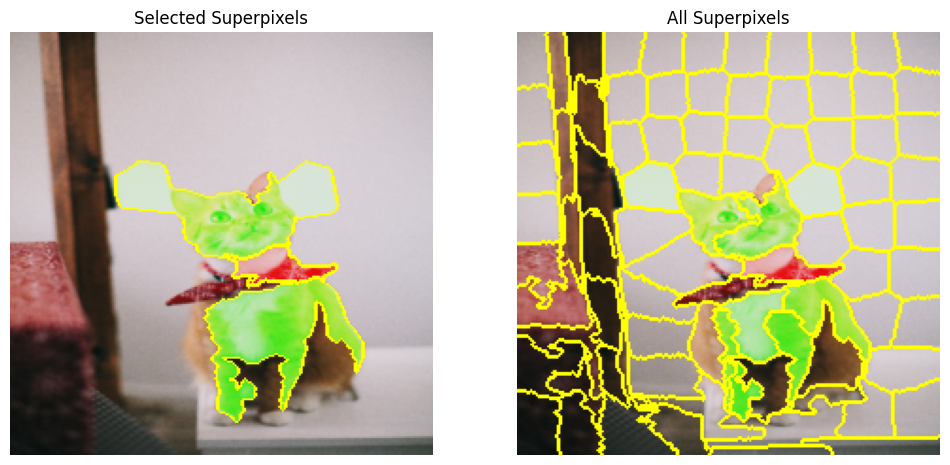

In [14]:
from skimage.segmentation import mark_boundaries #Return image with boundaries between labeled regions highlighted (https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.mark_boundaries)

target_label = explanation.top_labels[0]

# showing both Positive & Negative superpixels
temp, mask = explanation.get_image_and_mask(label=target_label, 
                                            positive_only=False, # if True, only take superpixels that positively contribute to the prediction of the label.
                                            num_features=10, #  number of superpixels to include in explanation
                                            hide_rest=False  # if True, make the non-explanation part of the return image gray
                                            )

segments = explanation.segments  # This assumes you have access to the 'segments' from your explanation object
img_boundry1 = mark_boundaries(temp/255.0, mask)
img_with_all_boundaries = mark_boundaries(temp / 255.0, segments)

print("image shape:", temp.shape)
print("mask shape:",mask.shape)
print("segments shape:", segments.shape)


# Creating subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plotting the image with selected superpixels on the left
ax[0].imshow(img_boundry1)
ax[0].set_title('Selected Superpixels')
ax[0].axis('off')  # Hide the axes

# Plotting the image with all superpixels on the right
ax[1].imshow(img_with_all_boundaries)
ax[1].set_title('All Superpixels')
ax[1].axis('off')  # Hide the axes

plt.show()



In the above image it can be seen that we selected 10 feateures to be highlighted, being 8 of them positive (green) and 2 of them negative (red). Below we explicitly ask them to provide us the 8 most important POSITIVE ones, and the 2 most importat NEGATIVE ones, which should match

Highlight only those features that POSITIVELY contribute to the explanations

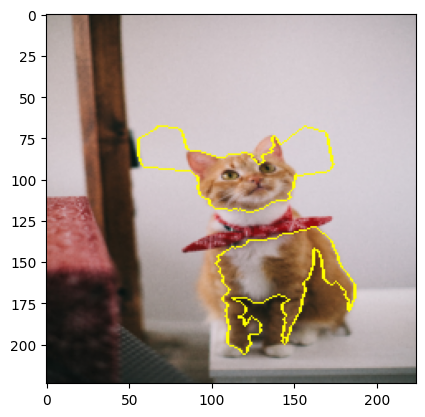

In [15]:
target_label = explanation.top_labels[0]

# showing only positve
temp2, mask2 = explanation.get_image_and_mask(label=target_label,
                                            positive_only=True, 
                                            num_features=9, 
                                            hide_rest=False)

img_boundry2 = mark_boundaries(temp2/255.0, mask2)
plt.imshow(img_boundry2)

Highlight only those features that NEGATIVELY contribute to the explanations

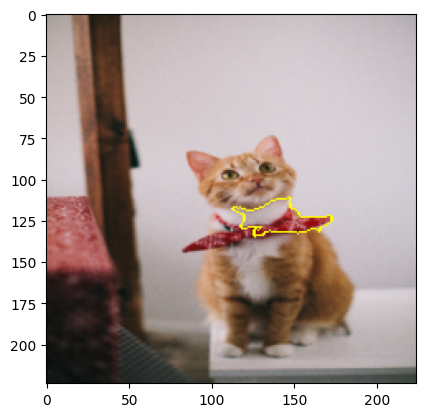

In [16]:
# showing only negative
temp3, mask3 = explanation.get_image_and_mask(label=target_label,
                                            positive_only=False,
                                            negative_only=True, 
                                            num_features=1, 
                                            hide_rest=False)

img_boundry3 = mark_boundaries(temp3/255.0, mask3)
plt.imshow(img_boundry3)

## Understanding MASK and SEGMENTS (how do they plot them)

- Segments: The segments variable refers to the segmentation of the entire image into superpixels. This segmentation is a preprocessing step in the LIME explanation where the image is divided into regions (superpixels) based on pixel similarity. Each unique value in the segments array represents a different superpixel. The shape of segments matches the image dimensions, where each pixel's value indicates the superpixel to which it belongs.

- Mask: The mask variable, on the other hand, is derived from the explanation model. It indicates which of the superpixels (from the segmentation done earlier) are relevant for explaining the prediction of the target label. The mask is binary (or boolean) in nature, with a True (or 1) value indicating that the corresponding superpixel positively or negatively contributes to the model's prediction (depending on the positive_only parameter), and a False (or 0) value indicating that the superpixel does not contribute significantly. The mask's shape corresponds to the number of superpixels, not the image's pixel dimensions.
    - ***when showing both the positive and negative feature values, it takes -1, 0 or -1 values***

In [17]:
print('***Number of unique segments:',np.unique(segments))
print('***Segments values:', segments)
print('***Number of unique values on mask:', np.unique(mask))

***Number of unique segments: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84]
***Segments values: [[ 1  1  1 ... 11 11 11]
 [ 1  1  1 ... 11 11 11]
 [ 1  1  1 ... 11 11 11]
 ...
 [78 78 78 ... 83 83 83]
 [78 78 78 ... 83 83 83]
 [78 78 78 ... 83 83 83]]
***Number of unique values on mask: [-1  0  1]


In [18]:
print('***Number of unique values on mask (positive+negative):', np.unique(mask))
print('***Number of unique values on mask2 (only positive):', np.unique(mask2))
print('***Number of unique values on mask3 (only neagtive):', np.unique(mask3))

***Number of unique values on mask (positive+negative): [-1  0  1]
***Number of unique values on mask2 (only positive): [0 1]
***Number of unique values on mask3 (only neagtive): [0 1]


 ## Let's see PLOT difference.

When comparing "positive+negative" w.r.t "only positive", we can see that:
- "positive+negative" uses -1 values to plot the positive values
- "positive" uses 0 values to plot the positive values

On the other hand, when comparing "positive+negative" w.r.t "only negative", we can see that:
- "positive+negative" uses 1 values to plot the negative values
- "negative" uses 0 values to plot the positive values

This is, in "positive+negative" the 0 is used to not show color.

However, when using either only positive or only negative, the 0 indeed represents when that value is highlighted 

### MASKS

In [19]:
for i in range(temp.shape[0]):
    for j in range(temp.shape[1]):
        # if temp[i,j].any() != temp3[i,j].any():
        if mask[i,j] != mask2[i,j]:
            print("Pixel[{},{}] is different, mask:{} and mask3:{}".format(i,j,mask[i,j],mask2[i,j]))
            

Pixel[112,146] is different, mask:-1 and mask3:0
Pixel[112,147] is different, mask:-1 and mask3:0
Pixel[113,139] is different, mask:-1 and mask3:0
Pixel[113,140] is different, mask:-1 and mask3:0
Pixel[113,141] is different, mask:-1 and mask3:0
Pixel[113,142] is different, mask:-1 and mask3:0
Pixel[113,143] is different, mask:-1 and mask3:0
Pixel[113,144] is different, mask:-1 and mask3:0
Pixel[113,145] is different, mask:-1 and mask3:0
Pixel[113,146] is different, mask:-1 and mask3:0
Pixel[114,136] is different, mask:-1 and mask3:0
Pixel[114,137] is different, mask:-1 and mask3:0
Pixel[114,138] is different, mask:-1 and mask3:0
Pixel[114,139] is different, mask:-1 and mask3:0
Pixel[114,140] is different, mask:-1 and mask3:0
Pixel[114,141] is different, mask:-1 and mask3:0
Pixel[114,142] is different, mask:-1 and mask3:0
Pixel[114,143] is different, mask:-1 and mask3:0
Pixel[114,144] is different, mask:-1 and mask3:0
Pixel[114,145] is different, mask:-1 and mask3:0
Pixel[114,146] is di

In [20]:
for i in range(temp.shape[0]):
    for j in range(temp.shape[1]):
        # if temp[i,j].any() != temp3[i,j].any():
        if mask[i,j] != mask3[i,j]:
            print("Pixel[{},{}] is different, mask:{} and mask3:{}".format(i,j,mask[i,j],mask3[i,j]))

Pixel[69,67] is different, mask:1 and mask3:0
Pixel[69,68] is different, mask:1 and mask3:0
Pixel[69,69] is different, mask:1 and mask3:0
Pixel[69,70] is different, mask:1 and mask3:0
Pixel[69,71] is different, mask:1 and mask3:0
Pixel[69,72] is different, mask:1 and mask3:0
Pixel[69,73] is different, mask:1 and mask3:0
Pixel[69,156] is different, mask:1 and mask3:0
Pixel[69,157] is different, mask:1 and mask3:0
Pixel[70,67] is different, mask:1 and mask3:0
Pixel[70,68] is different, mask:1 and mask3:0
Pixel[70,69] is different, mask:1 and mask3:0
Pixel[70,70] is different, mask:1 and mask3:0
Pixel[70,71] is different, mask:1 and mask3:0
Pixel[70,72] is different, mask:1 and mask3:0
Pixel[70,73] is different, mask:1 and mask3:0
Pixel[70,74] is different, mask:1 and mask3:0
Pixel[70,75] is different, mask:1 and mask3:0
Pixel[70,76] is different, mask:1 and mask3:0
Pixel[70,77] is different, mask:1 and mask3:0
Pixel[70,78] is different, mask:1 and mask3:0
Pixel[70,79] is different, mask:

### TEMP (3D image)

The error seems to be more related to how it deals with the "get_image_and_mask" functionality to update the temp variable; that issue can be solved by modifying the function as follows:

        if label not in self.local_exp:
            raise KeyError('Label not in explanation')
        if positive_only & negative_only:
            raise ValueError("Positive_only and negative_only cannot be true at the same time.")
        segments = self.segments
        image = self.image
        exp = self.local_exp[label]
        mask = np.zeros(segments.shape, segments.dtype)
        
        if hide_rest:
            temp = np.zeros(self.image.shape)
        else:
            temp = self.image.copy()

        # Prepare the list of features based on positive or negative impact
        if positive_only:
            fs = [x[0] for x in exp if x[1] > 0 and x[1] > min_weight][:num_features]
        elif negative_only:
            fs = [x[0] for x in exp if x[1] < 0 and abs(x[1]) > min_weight][:num_features]
        else:
            fs = [f for f, w in exp[:num_features] if np.abs(w) > min_weight]
        
        for f in fs:
            if positive_only or negative_only:
                temp[segments == f] = image[segments == f].copy()
                mask[segments == f] = 1
                if positive_only:
                    # Coloring positive segments in green
                    temp[segments == f, :] = [0, 255, 0]  # Assuming image is in 0-255 range
                elif negative_only:
                    # Coloring negative segments in red
                    temp[segments == f, :] = [255, 0, 0]
            else:
                # Default behavior for non-specified or both contributions
                for f, w in exp[:num_features]:
                    if np.abs(w) < min_weight:
                        continue
                    c = 0 if w < 0 else 1
                    mask[segments == f] = -1 if w < 0 else 1
                    temp[segments == f] = image[segments == f].copy()
                    temp[segments == f, c] = np.max(image)

## Changing the above code

In [21]:
from lime.lime_image import LimeImageExplainer

class CustomLimeImageExplainer(LimeImageExplainer):
    def get_image_and_mask(self, label, positive_only=True, negative_only=False, hide_rest=False,
                            num_features=5, min_weight=0.):
        """Init function.

        Args:
            label: label to explain
            positive_only: if True, only take superpixels that positively contribute to
                the prediction of the label.
            negative_only: if True, only take superpixels that negatively contribute to
                the prediction of the label. If false, and so is positive_only, then both
                negativey and positively contributions will be taken.
                Both can't be True at the same time
            hide_rest: if True, make the non-explanation part of the return
                image gray
            num_features: number of superpixels to include in explanation
            min_weight: minimum weight of the superpixels to include in explanation

        Returns:
            (image, mask), where image is a 3d numpy array and mask is a 2d
            numpy array that can be used with
            skimage.segmentation.mark_boundaries
        """
        if label not in self.local_exp:
            raise KeyError('Label not in explanation')
        if positive_only & negative_only:
            raise ValueError("Positive_only and negative_only cannot be true at the same time.")
        segments = self.segments
        image = self.image
        exp = self.local_exp[label]
        mask = np.zeros(segments.shape, segments.dtype)
        
        if hide_rest:
            temp = np.zeros(self.image.shape)
        else:
            temp = self.image.copy()
        
        # Prepare the list of features based on positive or negative impact
        if positive_only:
            fs = [x[0] for x in exp if x[1] > 0 and x[1] > min_weight][:num_features]
        elif negative_only:
            fs = [x[0] for x in exp if x[1] < 0 and abs(x[1]) > min_weight][:num_features]
        else:
            fs = [f for f, w in exp[:num_features] if np.abs(w) > min_weight]
        
        for f in fs:
            if positive_only or negative_only:
                temp[segments == f] = image[segments == f].copy()
                mask[segments == f] = 1
                if positive_only:
                    # Coloring positive segments in green
                    temp[segments == f, :] = [0, 255, 0]  # Assuming image is in 0-255 range
                elif negative_only:
                    # Coloring negative segments in red
                    temp[segments == f, :] = [255, 0, 0]
            else:
                # Default behavior for non-specified or both contributions
                for f, w in exp[:num_features]:
                    if np.abs(w) < min_weight:
                        continue
                    c = 0 if w < 0 else 1
                    mask[segments == f] = -1 if w < 0 else 1
                    temp[segments == f] = image[segments == f].copy()
                    temp[segments == f, c] = np.max(image)
                    
        return temp, mask


# LimeImageExplainer.get_image_and_mask = custom_get_image_and_mask
custom_explainer = CustomLimeImageExplainer() #https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_image
segmenter = SegmentationAlgorithm('slic',n_segments=100) 

custom_explanation = custom_explainer.explain_instance(image=np.array(pill_transf(img1)), 
                                         classifier_fn=batch_predict, # classification function
                                         top_labels=5, #produce explanations for the K labels with highest prediction probabilities
                                         hide_color=0, 
                                         num_samples=1000, # number of images that will be sent to classification function
                                         segmentation_fn = segmenter, # SegmentationAlgorithm, wrapped skimage
                                         num_features = 10,
                                         ) 

  0%|          | 0/1000 [00:00<?, ?it/s]

image shape: (224, 224, 3)
mask shape: (224, 224)
segments shape: (224, 224)


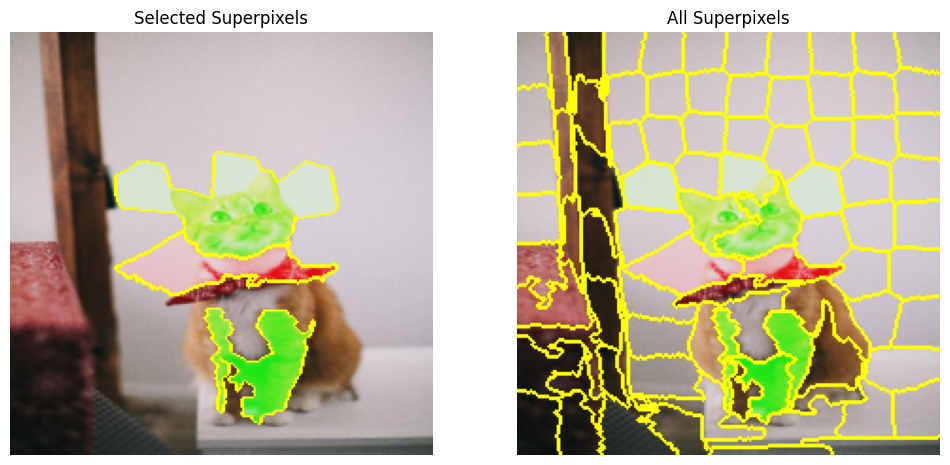

In [22]:
from skimage.segmentation import mark_boundaries #Return image with boundaries between labeled regions highlighted (https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.mark_boundaries)

target_label = custom_explanation.top_labels[0]

# showing both Positive & Negative superpixels
temp, mask = custom_explanation.get_image_and_mask(label=target_label, 
                                            positive_only=False, # if True, only take superpixels that positively contribute to the prediction of the label.
                                            num_features=10, #  number of superpixels to include in explanation
                                            hide_rest=False  # if True, make the non-explanation part of the return image gray
                                            )

segments = custom_explanation.segments  # This assumes you have access to the 'segments' from your explanation object
img_boundry1 = mark_boundaries(temp/255.0, mask)
img_with_all_boundaries = mark_boundaries(temp / 255.0, segments)

print("image shape:", temp.shape)
print("mask shape:",mask.shape)
print("segments shape:", segments.shape)


# Creating subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plotting the image with selected superpixels on the left
ax[0].imshow(img_boundry1)
ax[0].set_title('Selected Superpixels')
ax[0].axis('off')  # Hide the axes

# Plotting the image with all superpixels on the right
ax[1].imshow(img_with_all_boundaries)
ax[1].set_title('All Superpixels')
ax[1].axis('off')  # Hide the axes

plt.show()



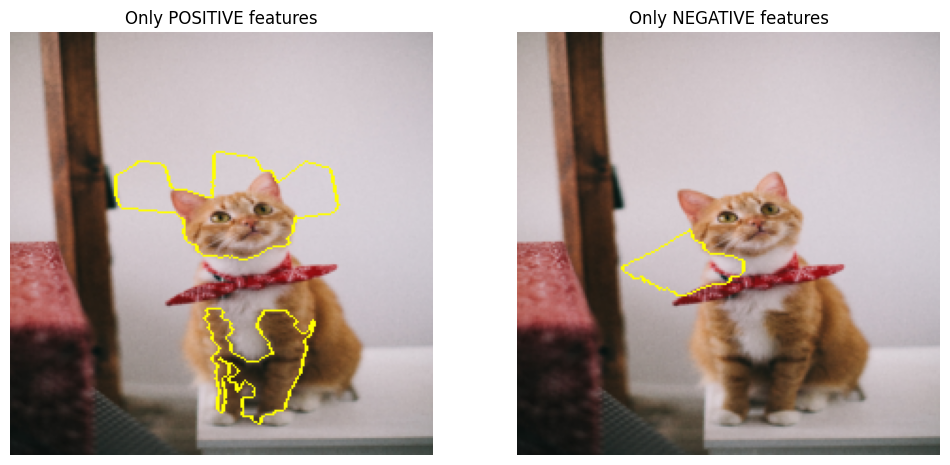

In [23]:
# showing only positve
temp2, mask2 = custom_explanation.get_image_and_mask(label=target_label,
                                            positive_only=True, 
                                            num_features=9, 
                                            hide_rest=False)

img_boundry2 = mark_boundaries(temp2/255.0, mask2)

# showing only negative
temp3, mask3 = custom_explanation.get_image_and_mask(label=target_label,
                                            positive_only=False,
                                            negative_only=True, 
                                            num_features=1, 
                                            hide_rest=False)

img_boundry3 = mark_boundaries(temp3/255.0, mask3)


# Creating subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plotting the image with selected superpixels on the left
ax[0].imshow(img_boundry2)
ax[0].set_title('Only POSITIVE features')
ax[0].axis('off')  # Hide the axes

# Plotting the image with all superpixels on the right
ax[1].imshow(img_boundry3)
ax[1].set_title('Only NEGATIVE features')
ax[1].axis('off')  # Hide the axes

plt.show()